<a href="https://colab.research.google.com/github/frehors/dl-exercises/blob/main/w6_MTL_star_student_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task in this notebook is to train a network which, given an image of a star, will calculate both the number of points on the star, as well as its width. 

Thus this will be a multi-task network, performing two completely different tasks simultaneously. 


In [12]:
#%% import stuff:

import matplotlib.pyplot as plt
import numpy as np
import pickle 

import torch
import torch.nn as nn

The cell below assumes you have already downloaded the dataset from brightspace, and put it in your google drive folder. It demonstrates how to use google drive together with a colab notebook.

In [3]:
temp=pickle.load(open('./data/starData.p','rb'))
X=temp['X']
y=temp['y']


tensor([5.0000, 3.1239])


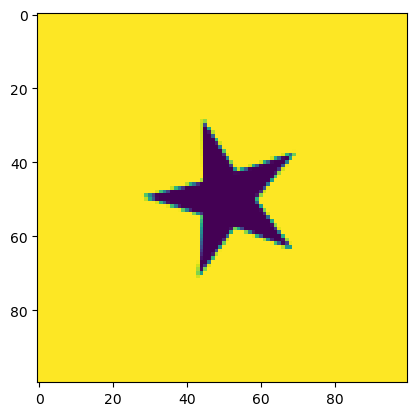

In [4]:
#Let's plot an example
idx=125
plt.imshow(np.squeeze(X[125,:,:,:],axis=0))
print(y[idx,:]) #first column is number of points, second is size of the star

In [19]:
#%% make datasets & loaders
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class StarDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return self.X[idx,:,:,:], self.y[idx,:] #return image and label

#make datasets


#split in val and train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


#make datasets (TensorDataset will do)
train_dataset = StarDataset(X_train, y_train)
val_dataset = StarDataset(X_val, y_val)

#make dataloaders
trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [10]:
#%% make network

#something simple like cnn-cnn-fc-relu-fc will do
num_input_channels=1
num_classes=2

class StarNet(nn.Module):
    def __init__(self):
        super(StarNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        # global pool
        self.fc1 = nn.Linear(320000, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x




#testing:
testData=torch.rand((1,1,100,100))
testNet=StarNet()
testNet.forward(testData)

tensor([[ 0.0151, -0.0567]], grad_fn=<AddmmBackward0>)

In [21]:
#%% define loss'es
loss1=nn.MSELoss()
loss2=nn.L1Loss()
loss_fn = lambda y_pred, y : 0.5 * loss1(y_pred, y) + 2 * loss2(y_pred, y) #some combination of loss1 and loss2

In [24]:
#%% train & validate

nEpoch=10

net=StarNet()
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)


for iEpoch in range(nEpoch):
   
    totTrainLoss = 0
    totValLoss = 0
    for xbatch,ybatch in trainLoader:
        optimizer.zero_grad()
        yhat=net.forward(xbatch)
        loss=loss_fn(yhat,ybatch)
        loss.backward()
        optimizer.step()
        totTrainLoss+=loss.item()
        
        #the usual. pass the output of your network to the custom loss function you made above
        #use it to update the weights
    
        
   
    for xbatch,ybatch in valLoader:
        yhat=net.forward(xbatch)
        loss=loss_fn(yhat,ybatch)
        totValLoss+=loss.item()
        #same as above, but now for the validation set
        #remember to watch the loss on the validation data
   



In [32]:
#evaluate
#plot model results
#plot loss
for xbatch,ybatch in valLoader:
    #xbatch, ybatch = xbatch.to(device), ybatch.to(device)
    yhat=net(xbatch)
    ax1 = plt.figure()
    classific = yhat.cpu().detach().numpy()[:,0].round()
    ax1.plot(classific, ybatch.cpu().detach().numpy()[:,0],'ro')
    ax1.xlabel('predicted')
    ax1.ylabel('true')
    ax2 = plt.figure()
    
    ax2.plot(yhat.cpu().detach().numpy()[:,1],ybatch.cpu().detach().numpy()[:,1],'go')
    ax2.xlabel('predicted')
    ax2.ylabel('true')
    
    
plt.show()

#plot accuracy


#try plotting predictions vs. targets for both training data and validation data in a scatterplot, and see how much variation you've captured

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 640x480 with 0 Axes>